# 1- Diffusion problem with zero boundary conditions


We want to solve:
$$
\begin{align*}
    -\Delta u &= f(x,y)\\
    u(x,y) &=0 \quad \forall x  \forall y  \in \partial \Omega
\end{align*}
$$
We set u = $(1-x^2)(1-y^2)$ the exact solution in order to find f(x,y)
$$
\begin{align*}
    u(x, y) &= (1-x^2)(1-y^2) \\
    &= 1 -y^2 -x^2(1-y^2) \\
\end{align*}
\\
\begin{align*}
    \frac{\partial u}{\partial x}(x, y) = -2x(1-y^2) \\
\end{align*}
\\
\begin{align*}
    \frac{\partial^2u}{\partial x^2}(x,y) = -2(1-y^2)
\end{align*}
$$
So, we want to solve the following problem:
$$
\begin{align*}
    -\Delta u &= 2(1-y^2) + 2(1-x^2)\\
    u(x,y) &=0 \quad \forall x  \forall y  \in \partial \Omega
\end{align*}
$$
We are going to minimise:
$$
\begin{align*}
    L = \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dx dy + \int_\Omega f(x,y)u(x,y)dx dy - \beta \frac{1}{N_{boundary}}\sum_{i=0}^{N_{boundary}}(u(x_i, y_i) - \hat{u}(x_i, y_i))^2
\end{align*}
$$
The advantage of this manufactured example is that we can compute exactly each term of the loss and know if we approximate it correctly:
$$
\begin{align*}
    \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dx dy &= \frac{1}{2}\int_{-1}^{1}\int_{-1}^{1}4x^2(1-y^2)^2dxdy \\
    &= \frac{128}{45}
\end{align*}
$$
$$
\begin{align*}
    \int_\Omega f(x,y)u(x,y)dx dy &= \frac{1}{2}\int_{-1}^{1}\int_{-1}^{1}(2(1-y^2)+2(1-x^2))(1-x^2)(1-y^2)dxdy \\
    &= \frac{256}{45}
\end{align*}
$$

In [1]:
# import dolfin
import sys, os
import torch
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from NeuralNetworks import fwdNN as fwd
from NeuralNetworks import residualNN as rnn
import plots
from fenics import *

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x_omega, ux_omega, fx, ux_boundary, cl_boundary, reg_boundary=500):
        grad_u = torch.autograd.grad(inputs=x_omega, outputs=ux_omega, grad_outputs=torch.ones_like(ux_omega), create_graph=True)[0]
        grad_ux1, grad_ux2 = grad_u[:, 0], grad_u[:, 1]
        
        physical_term1 = grad_ux1.pow(2) + grad_ux2.pow(2)
        physical_term2 = fx*ux_omega
        boundary_term = (cl_boundary - ux_boundary).pow(2)

        loss_term1 = 4/2*physical_term1.mean()
        loss_term2 = 4*physical_term2.mean()
        loss_term3 = boundary_term.mean()
        loss = loss_term1 - loss_term2 + reg_boundary*loss_term3

        return loss, loss_term1, loss_term2, loss_term3
    
class Omega2D(Dataset):
    def __init__(self, train_type=0, n_omega=100, n_boundary=75, x_bounds=[-1, 1], y_bounds=[-1, 1]):

        self.n_omega = n_omega
        self.n_boundary = n_boundary
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

        self.omega_train, self.boundary_train = self._create_points_for_training(train_type)

    def _create_points_for_training(self, train_type):
        if train_type == 0:
            xmin, xmax = self.x_bounds
            ymin, ymax = self.y_bounds

            x = np.random.uniform(xmin, xmax, self.n_omega)
            y = np.random.uniform(ymin, ymax, self.n_omega)
            omega_coordinates = np.column_stack((x, y))

            n_per_boundary = self.n_boundary//4
            x_left, y_left = xmin*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
            x_right, y_right = xmax*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
            x_bottom, y_bottom = np.random.uniform(xmin, xmax, n_per_boundary), ymin*np.ones(n_per_boundary)
            x_top, y_top = np.random.uniform(xmin, xmax, n_per_boundary), ymax*np.ones(n_per_boundary)
            x_boundary = np.concatenate((x_left, x_right, x_bottom, x_top))
            y_boundary = np.concatenate((y_left, y_right, y_bottom, y_top))
            boundary_coordinates = np.column_stack((x_boundary, y_boundary))

            return omega_coordinates, boundary_coordinates
        else:
            N = 9
            mesh = RectangleMesh(Point(-1, -1), Point(1, 1), N, N)

            class Boundary(SubDomain):
                def inside(self, x, on_boundary):
                    return (near(x[0], -1) or near(x[0], 1) or near(x[1], -1) or near(x[1], 1))

            boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
            boundary_markers.set_all(0)
            boundary = Boundary()

            boundary_coordinates = set()
            omega_coordinates = set()

            for vertex in vertices(mesh):
                x = vertex.point().array()  
                if boundary.inside(x, True):
                    boundary_coordinates.add((x[0], x[1]))
                else:
                    omega_coordinates.add((x[0], x[1]))

            boundary_coordinates = np.array(list(boundary_coordinates))
            omega_coordinates = np.array(list(omega_coordinates))

            return omega_coordinates, boundary_coordinates
    
    def plot(self):
        plt.scatter(self.omega_train[:, 0], self.omega_train[:, 1], c='blue', alpha=0.6, label='Omega points')
        plt.scatter(self.boundary_train[:, 0], self.boundary_train[:, 1], c='red', alpha=0.6, label='Boundary points')
        plt.title('Domain with corner singularity along the x-axis at y=0')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

In [4]:
class ExampleOne():
    def __init__(self, hidden_size=20, NN='res'):
        
        if NN == 'fwd':
            self.model = fwd.FullyConnectedNetwork(input_dim=2, hidden_size=hidden_size).to(device)
            self.sig = 'fwd'
        else:
            self.model = rnn.RitzModel(input_dim=2, num_blocks=4, hidden_size=hidden_size).to(device)
            self.sig = 'res'
        self.criterion = DeepRitzLoss()

        self.total_loss = []
        self.physical_loss1 = []
        self.physical_loss2 = []
        self.boundary_loss = []

    def train_config1(self, n_iter, n_omega, n_boundary, beta):

        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0005)
        self.model.train()

        model_name = f'ex1_{self.sig}_iter{n_iter//1000}k_{n_omega}_{n_boundary}_beta{beta}.pth'
        
        for iter_i in range(n_iter):
            integration_grid = Omega2D(0, n_omega, n_boundary)

            x_omega = torch.FloatTensor(integration_grid.omega_train).to(device)
            x_boundary = torch.FloatTensor(integration_grid.boundary_train).to(device)
            fx_omega = (torch.FloatTensor(self.f(x_omega.cpu())).unsqueeze(1)).to(device)
            cl_boundary = self.cl_boundary(x_boundary).to(device)
            x_omega.requires_grad = True

            model_optimizer.zero_grad()
            ux_omega = self.model(x_omega)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary, beta)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')
        torch.save(self.model.state_dict(), f'./Models/{model_name}')

    def train_config2(self, n_iter, beta):
        """
            Integration points generated only once using a uniform grid with fewer points
        """

        model_name = f'ex1_{self.sig}_iter{n_iter//1000}k_beta{beta}_config2.pth'
        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0005)
        integration_grid = Omega2D(1)
        x_omega = torch.FloatTensor(integration_grid.omega_train).to(device)
        x_boundary = torch.FloatTensor(integration_grid.boundary_train).to(device)
        fx_omega = (torch.FloatTensor(self.f(x_omega.cpu())).unsqueeze(1)).to(device)
        cl_boundary = self.cl_boundary(x_boundary).to(device)
        x_omega.requires_grad = True
        self.model.train()

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            ux_omega = self.model(x_omega)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary, beta)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')
        torch.save(self.model.state_dict(), f'./Models/{model_name}')

    def cl_boundary(self, x):
        return torch.zeros(x.shape[0], 1)
    
    def f(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        fx = 2*(1-x2**2) + 2*(1-x1**2)
        return fx
    
    def u(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        u = (1-x1**2)*(1-x2**2)
        return u
    
    def du_x1_exact(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        du_x1 = -2*x1*(1-x2**2)
        return du_x1
    
    def du_x2_exact(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        du_x2 = -2*x2*(1-x1**2)
        return du_x2
    
    def plot_config2(self):

        plt.plot(self.physical_loss1, label=r'$\nabla_x u \cdot \nabla_x u$', color='blue')
        plt.plot(np.ones(len(self.physical_loss1))*128/45, label=r'Analytical solution of $\nabla_x u \cdot \nabla_x u$', color='#00008B')
        plt.plot(self.physical_loss2, label=r'fu', color='orange')
        plt.plot(np.ones(len(self.physical_loss2))*256/45, label=r'Analytical solution of $fu$', color='red')
        plt.legend()
        plt.xlabel('Iterations')

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(self.boundary_loss, label=r'$(u - c_l)^2$', color='black')
        ax[0].legend()
        ax[0].set_xlabel('Iterations')
        ax[0].set_yscale('log')

        ax[1].plot(np.array(self.total_loss) - 64/45 + 256/45, label='Total loss', color='black')
        ax[1].legend()
        ax[1].set_xlabel('Iterations')
        ax[1].set_yscale('log')

        plt.tight_layout()

In [5]:
torch.manual_seed(15)

In [6]:
model1 = ExampleOne(hidden_size=20, NN='fwd')
# model1.train_config1(n_iter=1000, n_omega=10000, n_boundary=2500, beta=500)
model1.train_config2(n_iter=100, beta=500)

/home/lucas/.local/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration 0, loss: 17.000003814697266


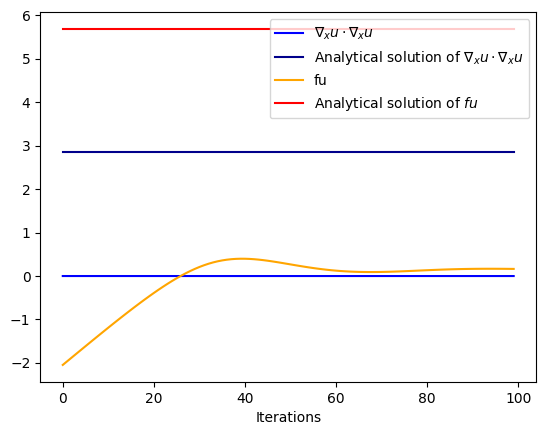

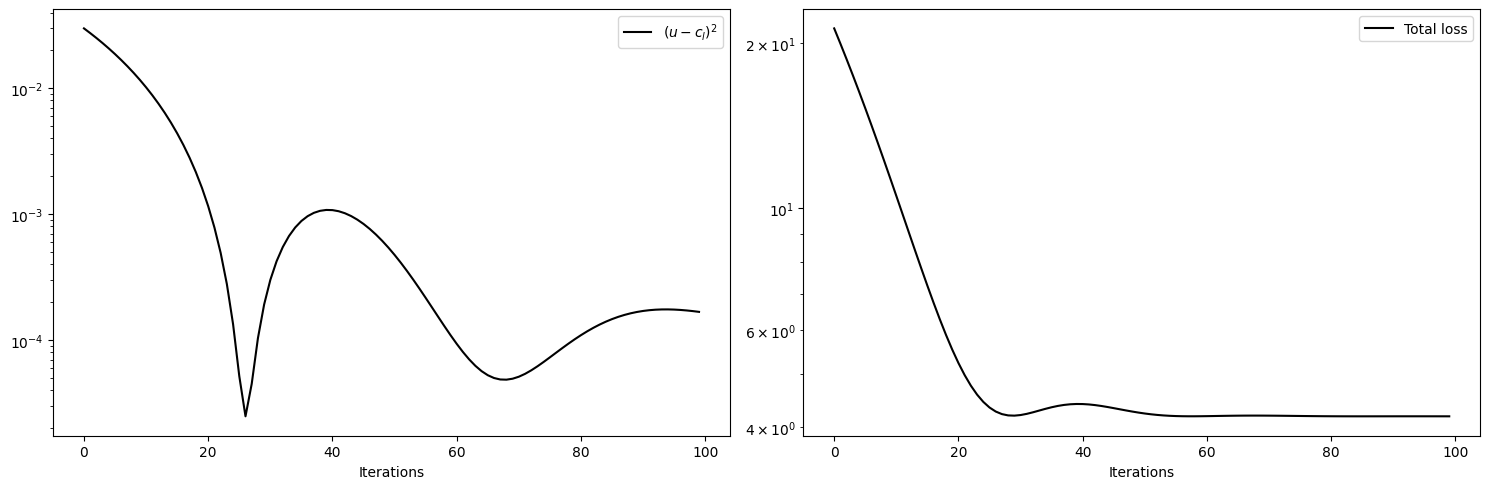

In [7]:
model1.plot_config2()

In [8]:
def asses_solution(example: ExampleOne, model_name: str, grid_size: int):
    mesh_coordinates = (RectangleMesh(Point(-1, -1), Point(1, 1), grid_size, grid_size)).coordinates()
    evaluation_domain_points = torch.FloatTensor(mesh_coordinates).to(device)
    evaluation_domain_points.requires_grad = True

    model = example.model
    model.eval()

    u_pred = model(evaluation_domain_points)
    u_exact = (example.u(evaluation_domain_points.cpu()).unsqueeze(1)).to(device)
    u_pred_reshaped = plots.reshape_tensor_to_cpu(u_pred, grid_size)
    u_exact_reshaped = plots.reshape_tensor_to_cpu(u_exact, grid_size)

    du_pred_x1, du_pred_x2 = plots.partial_derivative_2D(u=u_pred,x=evaluation_domain_points)
    du_exact_x1, du_exact_x2 = example.du_x1_exact(evaluation_domain_points), example.du_x2_exact(evaluation_domain_points) 
    du_pred_x1_reshaped, du_pred_x2_reshaped = plots.reshape_tensor_to_cpu(du_pred_x1, grid_size), plots.reshape_tensor_to_cpu(du_pred_x2, grid_size)
    du_exact_x1_reshaped, du_exact_x2_reshaped = plots.reshape_tensor_to_cpu(du_exact_x1, grid_size), plots.reshape_tensor_to_cpu(du_exact_x2, grid_size)

    mae = plots.compute_mae(plots.to_cpu(u_pred), plots.to_cpu(u_exact))
    err_relative_l2 = plots.compute_l2_relative_error(u_pred, u_exact)
    err_relative_h1 = plots.compute_h1_relative_error(u_pred, u_exact, evaluation_domain_points)

    fig0 = plots.plot_config1(u_pred_reshaped, u_exact_reshaped, 'U')
    fig1 = plots.plot_config1(du_pred_x1_reshaped, du_exact_x1_reshaped, 'du/dx1')
    fig2 = plots.plot_config1(du_pred_x2_reshaped, du_exact_x2_reshaped, 'du/dx2')

Gradient computation: dim ok
Mean absolute error: 5.909750461578369
l2_relative_error: 15.319376499968454, l2_u_true: 4.7992682456970215, l2_u_pred: 77.98855590820312
h1_relative_error: 37.64928011126272, h1_u_true: 13.396028518676758, h1_u_pred: 513.5948486328125


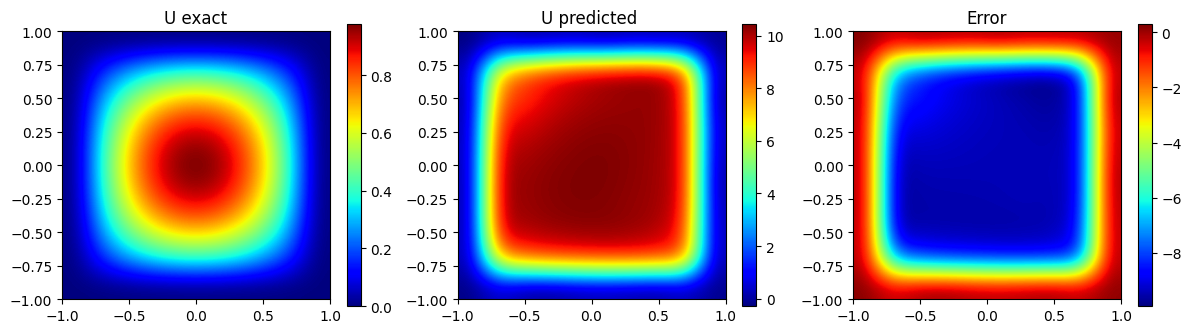

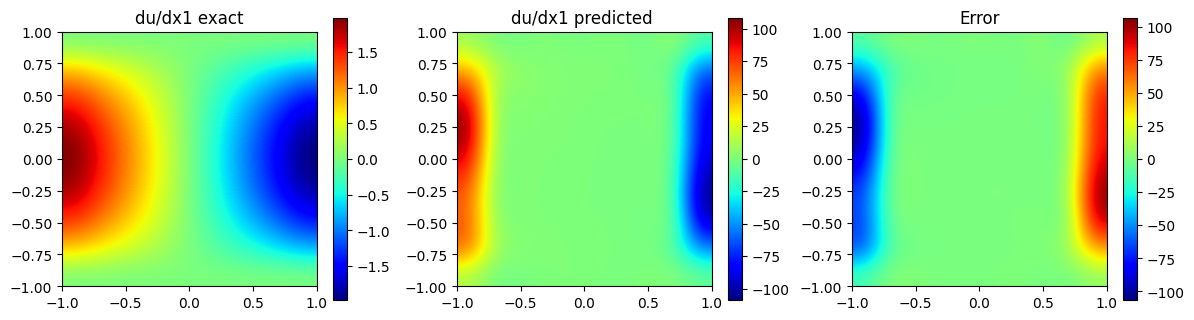

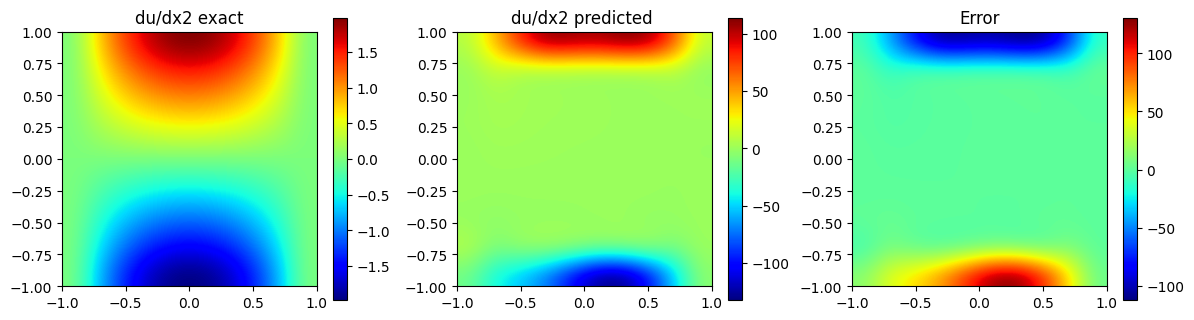

In [9]:
# model_name = 'ex1_res_iter10k_10000_2500_beta5000'
model_name = 'ex1_fwd_iter10k_beta500_config2'
if model_name.split('_')[1] == 'res':
    example = ExampleOne(hidden_size=20, NN='res')
else:
    example = ExampleOne(hidden_size=20, NN='fwd')

example.model.load_state_dict(torch.load('./Models/'+model_name+'.pth', weights_only=True))
asses_solution(example, 'model_name', 9)